In [1]:
import os
import csv
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import tqdm
import torch
from torch import nn, optim
from torchvision import models, transforms
from torchvision.transforms import AutoAugmentPolicy
from torch.utils.data import Dataset, DataLoader, ConcatDataset

In [2]:
def same_seeds(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
same_seeds(777)

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [4]:
train_gt = pd.read_csv('hw4_data/office/train.csv')
train_gt = train_gt.drop(columns='id')
train_gt

,filename,label
0,Couch00015.jpg,Couch
1,Helmet00018.jpg,Helmet
2,Refrigerator00011.jpg,Refrigerator
3,Alarm_Clock00061.jpg,Alarm_Clock
4,Bike00088.jpg,Bike
...,...,...
3946,Mouse00019.jpg,Mouse
3947,Chair00046.jpg,Chair
3948,Candles00017.jpg,Candles
3949,Flowers00013.jpg,Flowers


In [5]:
# class2label_dict = {}
# label2class_dict = {}
# for i, c in enumerate(list(set(train_gt['label']))):
#     class2label_dict[c] = i
#     label2class_dict[i] = c

In [6]:
class2label_dict = {'TV': 0,
 'Desk_Lamp': 1,
 'Speaker': 2,
 'Hammer': 3,
 'Folder': 4,
 'Laptop': 5,
 'Pen': 6,
 'Postit_Notes': 7,
 'Mop': 8,
 'Mug': 9,
 'Radio': 10,
 'File_Cabinet': 11,
 'Eraser': 12,
 'Ruler': 13,
 'Couch': 14,
 'Trash_Can': 15,
 'Webcam': 16,
 'Backpack': 17,
 'Bucket': 18,
 'Kettle': 19,
 'Batteries': 20,
 'Telephone': 21,
 'Chair': 22,
 'Toys': 23,
 'Refrigerator': 24,
 'Clipboards': 25,
 'Fork': 26,
 'Push_Pin': 27,
 'Marker': 28,
 'Candles': 29,
 'Flipflops': 30,
 'Helmet': 31,
 'Pencil': 32,
 'Calendar': 33,
 'Monitor': 34,
 'Shelf': 35,
 'Sneakers': 36,
 'Soda': 37,
 'Bottle': 38,
 'Flowers': 39,
 'Drill': 40,
 'Table': 41,
 'Knives': 42,
 'Computer': 43,
 'Alarm_Clock': 44,
 'Sink': 45,
 'Exit_Sign': 46,
 'Bed': 47,
 'Oven': 48,
 'Keyboard': 49,
 'Paper_Clip': 50,
 'Lamp_Shade': 51,
 'Scissors': 52,
 'Curtains': 53,
 'Fan': 54,
 'Spoon': 55,
 'Screwdriver': 56,
 'Glasses': 57,
 'Pan': 58,
 'ToothBrush': 59,
 'Mouse': 60,
 'Printer': 61,
 'Calculator': 62,
 'Notebook': 63,
 'Bike': 64}

In [7]:
class Office_Dataset(Dataset):
    def __init__(self, img_dir, csv_path, transform=None):
        self.gt = pd.read_csv(csv_path)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.gt)

    def __getitem__(self, idx):
        idx_row = self.gt.loc[idx]
        img_name = idx_row['filename']
        img_path = f'{self.img_dir}/{img_name}'
        image = Image.open(img_path)
        label = class2label_dict[idx_row['label']]
        if self.transform:
            image = self.transform(image)
        return image, label

In [8]:
batch_size = 128

transform_1 = transforms.Compose([transforms.Resize(128),
                                transforms.AutoAugment(policy=AutoAugmentPolicy.IMAGENET),
                                transforms.CenterCrop((128,128)),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                     std=[0.229, 0.224, 0.225])
                               ])
transform_2 = transforms.Compose([transforms.Resize(128),
                                transforms.AutoAugment(policy=AutoAugmentPolicy.CIFAR10),
                                transforms.CenterCrop((128,128)),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                     std=[0.229, 0.224, 0.225])
                               ])
transform_3 = transforms.Compose([transforms.Resize(128),
                                transforms.AutoAugment(policy=AutoAugmentPolicy.SVHN),
                                transforms.CenterCrop((128,128)),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                     std=[0.229, 0.224, 0.225])
                               ])
transform_test = transforms.Compose([transforms.Resize(128),
                                transforms.CenterCrop((128,128)),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                     std=[0.229, 0.224, 0.225])
                               ])

In [9]:
office_train_img_dir = 'D:/NTU/DLCV/hw4/hw4_data/office/train/'
office_train_csv_path = 'D:/NTU/DLCV/hw4/hw4_data/office/train.csv'
office_val_img_dir = 'D:/NTU/DLCV/hw4/hw4_data/office/val/'
office_val_csv_path = 'D:/NTU/DLCV/hw4/hw4_data/office/val.csv'

office_train_1 = Office_Dataset(office_train_img_dir, office_train_csv_path, transform=transform_1)
office_train_2 = Office_Dataset(office_train_img_dir, office_train_csv_path, transform=transform_2)
office_train_3 = Office_Dataset(office_train_img_dir, office_train_csv_path, transform=transform_3)
office_train_4 = Office_Dataset(office_train_img_dir, office_train_csv_path, transform=transform_test)
office_train_dataset = ConcatDataset([office_train_1, office_train_2, office_train_3, office_train_4])
office_train_dataloader = DataLoader(office_train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)

office_val_dataset = Office_Dataset(office_val_img_dir, office_val_csv_path, transform=transform_test)
office_val_dataloader = DataLoader(office_val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

In [10]:
images, labels = next(iter(office_train_dataloader))
print(images.shape, labels.shape)

torch.Size([128, 3, 128, 128]) torch.Size([128])


In [11]:
class model_ft(nn.Module):
    def __init__(self):
        super(model_ft, self).__init__()
        self.backbone = models.resnet50(weights=None)
#         self.backbone.load_state_dict(torch.load('hw4_data/pretrain_model_SL.pt'))
        self.backbone.load_state_dict(torch.load('p2_ckpt/backbone.pt')['model_state_dict'])
        self.classifier = nn.Sequential(nn.BatchNorm1d(1000),
                                        nn.ReLU(),
                                        nn.Dropout(p=0.5),
                                        nn.Linear(1000, 512),
                                        nn.BatchNorm1d(512),
                                        nn.ReLU(),
                                        nn.Dropout(p=0.5),
                                        nn.Linear(512, 65)
                                       )
        # freeze backbone
        for parameter in self.backbone.parameters():   
            parameter.requires_grad = False
            
    def forward(self, x):
        x = self.backbone(x)
        x = self.classifier(x)
        return x
    
p2_model = model_ft()
# p2_model = torch.load('p2_ckpt/best_model_C.pt')
p2_model.to(device)

best_model = model_ft()
best_acc = 0

record = {'train_loss':[], 'train_acc':[], 'val_loss':[], 'val_acc':[]}

In [12]:
def record_append(r, a, b, c, d):
    r['train_loss'].append(a)
    r['train_acc'].append(b)
    r['val_loss'].append(c)
    r['val_acc'].append(d)
    
def plot_record(r):
    plt.figure(figsize=(10,6))
    plt.subplot(2,1,1)
    plt.plot(r['train_loss'], label='train_loss')
    plt.plot(r['val_loss'], label='val_loss')
    plt.legend()
    plt.grid()
    plt.subplot(2,1,2)
    plt.plot(r['train_acc'], label='train_acc')
    plt.plot(r['val_acc'], label='val_acc')
    plt.legend()
    plt.grid()
    plt.show()

In [13]:
def train_loop(dataloader, model, loss_fn, optimizer, scheduler=None):
    model.train()
    batch_num = len(dataloader)
    train_loss, train_acc = 0, 0
    with tqdm.tqdm(total=batch_num) as pbar:
        pbar.set_description(f'epoch {e}')
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            pred_labels = model(images)
            loss = loss_fn(pred_labels, labels)
            acc = ((pred_labels.argmax(1)==labels).sum()/len(labels))
            train_loss += loss.item()
            train_acc += acc.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            pbar.set_postfix({'loss': loss.item(), 'acc': acc.item()})
            pbar.update(1)
    if scheduler is not None:
        scheduler.step(train_loss)
    train_loss /= batch_num
    train_acc /= batch_num
    print(f"Train | Avg_loss: {train_loss:>8f}, Accuracy: {(100*train_acc):>0.1f}%")
    return train_loss, train_acc
    

def val_loop(dataloader, model, loss_fn):
    model.eval()
#     total, hit = 0, 0
    batch_num = len(dataloader)
    val_loss, val_acc = 0, 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            pred_labels = model(images)
            loss = loss_fn(pred_labels, labels)
            acc = (pred_labels.argmax(1)==labels).sum()/len(labels)
            val_loss += loss.item()
            val_acc += acc.item()
#             hit += (pred_labels.argmax(1)==labels).sum()
#             total += len(labels)
    val_loss /= batch_num
    val_acc /= batch_num
#     print(hit/total)
    print(f"Validation | Avg_loss: {val_loss:>8f}, Accuracy: {(100*val_acc):>0.1f}%")
    return val_loss, val_acc

In [14]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(p2_model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

epoch 1: 100%|████████████████████████████████████████████████| 124/124 [04:03<00:00,  1.96s/it, loss=3.88, acc=0.0667]


Train | Avg_loss: 4.002434, Accuracy: 7.2%
Validation | Avg_loss: 3.485254, Accuracy: 23.5%
new best acc: 0.23508523404598236


epoch 2: 100%|██████████████████████████████████████████████████| 124/124 [04:04<00:00,  1.97s/it, loss=3.46, acc=0.15]


Train | Avg_loss: 3.672953, Accuracy: 13.1%
Validation | Avg_loss: 3.262176, Accuracy: 26.4%
new best acc: 0.26438210904598236


epoch 3: 100%|█████████████████████████████████████████████████| 124/124 [03:57<00:00,  1.91s/it, loss=3.53, acc=0.217]


Train | Avg_loss: 3.505540, Accuracy: 15.7%
Validation | Avg_loss: 3.120661, Accuracy: 28.8%
new best acc: 0.28781960904598236


epoch 4: 100%|█████████████████████████████████████████████████| 124/124 [03:53<00:00,  1.88s/it, loss=3.39, acc=0.183]


Train | Avg_loss: 3.393490, Accuracy: 17.7%
Validation | Avg_loss: 3.037662, Accuracy: 31.1%
new best acc: 0.3109019920229912


epoch 5: 100%|█████████████████████████████████████████████████| 124/124 [03:57<00:00,  1.91s/it, loss=3.27, acc=0.283]


Train | Avg_loss: 3.320538, Accuracy: 19.1%
Validation | Avg_loss: 2.967227, Accuracy: 32.3%
new best acc: 0.3226207420229912


epoch 6: 100%|███████████████████████████████████████████████████| 124/124 [03:57<00:00,  1.92s/it, loss=3.37, acc=0.2]


Train | Avg_loss: 3.267078, Accuracy: 19.9%
Validation | Avg_loss: 2.899599, Accuracy: 32.3%


epoch 7: 100%|█████████████████████████████████████████████████| 124/124 [03:54<00:00,  1.89s/it, loss=3.32, acc=0.183]


Train | Avg_loss: 3.205259, Accuracy: 21.1%
Validation | Avg_loss: 2.857614, Accuracy: 33.6%
new best acc: 0.3362926170229912


epoch 8: 100%|███████████████████████████████████████████████████| 124/124 [03:53<00:00,  1.88s/it, loss=2.85, acc=0.3]


Train | Avg_loss: 3.150020, Accuracy: 21.9%
Validation | Avg_loss: 2.805488, Accuracy: 34.0%
new best acc: 0.3401988670229912


epoch 9: 100%|█████████████████████████████████████████████████| 124/124 [03:51<00:00,  1.86s/it, loss=2.91, acc=0.267]


Train | Avg_loss: 3.116416, Accuracy: 22.2%
Validation | Avg_loss: 2.772065, Accuracy: 34.0%


epoch 10: 100%|████████████████████████████████████████████████| 124/124 [03:49<00:00,  1.85s/it, loss=2.85, acc=0.283]


Train | Avg_loss: 3.089926, Accuracy: 22.7%
Validation | Avg_loss: 2.742543, Accuracy: 35.2%
new best acc: 0.3515625


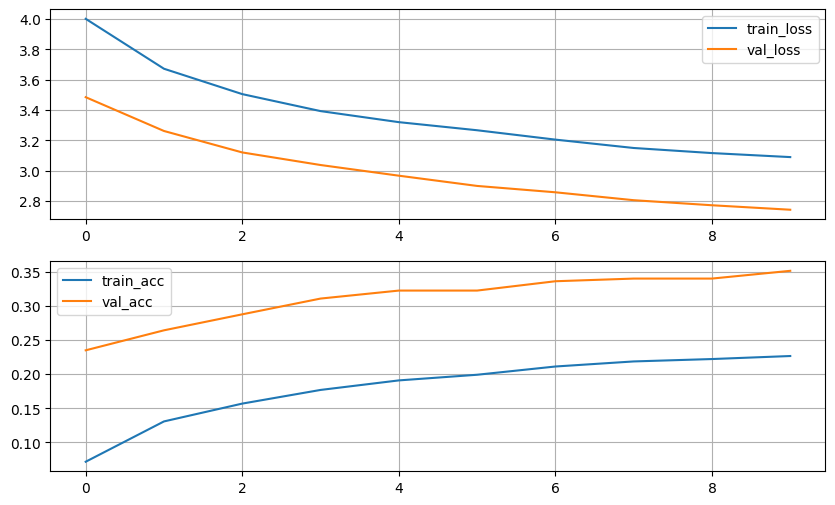

epoch 11: 100%|████████████████████████████████████████████████| 124/124 [03:52<00:00,  1.87s/it, loss=3.09, acc=0.183]


Train | Avg_loss: 3.058221, Accuracy: 23.3%
Validation | Avg_loss: 2.701101, Accuracy: 35.5%
new best acc: 0.35546875


epoch 12: 100%|█████████████████████████████████████████████████| 124/124 [03:52<00:00,  1.88s/it, loss=2.97, acc=0.25]


Train | Avg_loss: 3.041272, Accuracy: 23.3%
Validation | Avg_loss: 2.655572, Accuracy: 35.9%
new best acc: 0.359375


epoch 13: 100%|████████████████████████████████████████████████| 124/124 [03:53<00:00,  1.88s/it, loss=2.95, acc=0.317]


Train | Avg_loss: 3.000594, Accuracy: 24.1%
Validation | Avg_loss: 2.623714, Accuracy: 35.5%


epoch 14: 100%|█████████████████████████████████████████████████| 124/124 [03:50<00:00,  1.86s/it, loss=3.1, acc=0.167]


Train | Avg_loss: 2.980427, Accuracy: 24.4%
Validation | Avg_loss: 2.627100, Accuracy: 36.5%
new best acc: 0.365234375


epoch 15: 100%|████████████████████████████████████████████████| 124/124 [04:14<00:00,  2.05s/it, loss=2.91, acc=0.233]


Train | Avg_loss: 2.955582, Accuracy: 25.0%
Validation | Avg_loss: 2.603134, Accuracy: 36.5%


epoch 16: 100%|█████████████████████████████████████████████████| 124/124 [04:23<00:00,  2.13s/it, loss=3.2, acc=0.167]


Train | Avg_loss: 2.944313, Accuracy: 25.4%
Validation | Avg_loss: 2.575345, Accuracy: 36.9%
new best acc: 0.369140625


epoch 17: 100%|████████████████████████████████████████████████| 124/124 [04:22<00:00,  2.12s/it, loss=2.97, acc=0.217]


Train | Avg_loss: 2.931867, Accuracy: 25.8%
Validation | Avg_loss: 2.568809, Accuracy: 36.3%


epoch 18: 100%|████████████████████████████████████████████████| 124/124 [04:23<00:00,  2.12s/it, loss=2.96, acc=0.233]


Train | Avg_loss: 2.913004, Accuracy: 26.1%
Validation | Avg_loss: 2.570535, Accuracy: 36.5%


epoch 19: 100%|█████████████████████████████████████████████████| 124/124 [04:24<00:00,  2.13s/it, loss=3.1, acc=0.217]


Train | Avg_loss: 2.887800, Accuracy: 26.1%
Validation | Avg_loss: 2.547524, Accuracy: 36.9%


epoch 20: 100%|████████████████████████████████████████████████| 124/124 [04:26<00:00,  2.15s/it, loss=2.98, acc=0.183]


Train | Avg_loss: 2.875111, Accuracy: 26.5%
Validation | Avg_loss: 2.514366, Accuracy: 37.3%
new best acc: 0.373046875


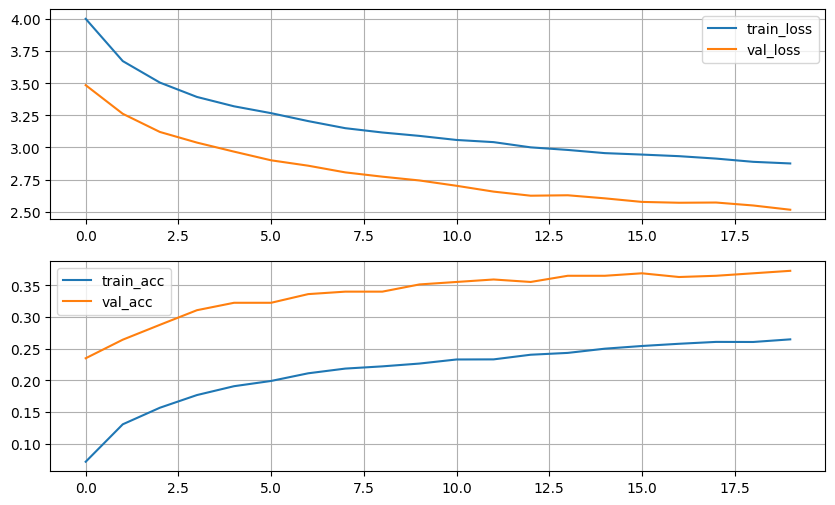

epoch 21: 100%|██████████████████████████████████████████████████| 124/124 [04:26<00:00,  2.15s/it, loss=2.82, acc=0.3]


Train | Avg_loss: 2.865934, Accuracy: 26.8%
Validation | Avg_loss: 2.527735, Accuracy: 37.5%
new best acc: 0.375


epoch 22: 100%|████████████████████████████████████████████████| 124/124 [04:26<00:00,  2.15s/it, loss=2.92, acc=0.267]


Train | Avg_loss: 2.850922, Accuracy: 26.4%
Validation | Avg_loss: 2.507384, Accuracy: 37.9%
new best acc: 0.37890625


epoch 23: 100%|█████████████████████████████████████████████████| 124/124 [04:21<00:00,  2.11s/it, loss=2.93, acc=0.25]


Train | Avg_loss: 2.843794, Accuracy: 27.1%
Validation | Avg_loss: 2.480169, Accuracy: 36.7%


epoch 24: 100%|██████████████████████████████████████████████████| 124/124 [04:21<00:00,  2.11s/it, loss=2.84, acc=0.3]


Train | Avg_loss: 2.832886, Accuracy: 27.2%
Validation | Avg_loss: 2.480636, Accuracy: 37.5%


epoch 25: 100%|████████████████████████████████████████████████| 124/124 [04:24<00:00,  2.14s/it, loss=3.14, acc=0.233]


Train | Avg_loss: 2.814452, Accuracy: 27.6%
Validation | Avg_loss: 2.472056, Accuracy: 38.1%
new best acc: 0.380859375


epoch 26: 100%|█████████████████████████████████████████████████| 124/124 [04:23<00:00,  2.13s/it, loss=3.32, acc=0.15]


Train | Avg_loss: 2.808342, Accuracy: 27.6%
Validation | Avg_loss: 2.469049, Accuracy: 38.3%
new best acc: 0.3828125


epoch 27: 100%|████████████████████████████████████████████████| 124/124 [04:21<00:00,  2.11s/it, loss=2.67, acc=0.333]


Train | Avg_loss: 2.792250, Accuracy: 27.7%
Validation | Avg_loss: 2.459077, Accuracy: 37.3%


epoch 28: 100%|████████████████████████████████████████████████| 124/124 [04:25<00:00,  2.14s/it, loss=2.87, acc=0.217]


Train | Avg_loss: 2.793654, Accuracy: 27.9%
Validation | Avg_loss: 2.439183, Accuracy: 37.7%


epoch 29: 100%|████████████████████████████████████████████████| 124/124 [03:58<00:00,  1.92s/it, loss=2.59, acc=0.267]


Train | Avg_loss: 2.763896, Accuracy: 28.4%
Validation | Avg_loss: 2.435068, Accuracy: 39.1%
new best acc: 0.390625


epoch 30: 100%|████████████████████████████████████████████████| 124/124 [03:50<00:00,  1.86s/it, loss=2.37, acc=0.533]


Train | Avg_loss: 2.764392, Accuracy: 29.1%
Validation | Avg_loss: 2.443833, Accuracy: 39.5%
new best acc: 0.39453125


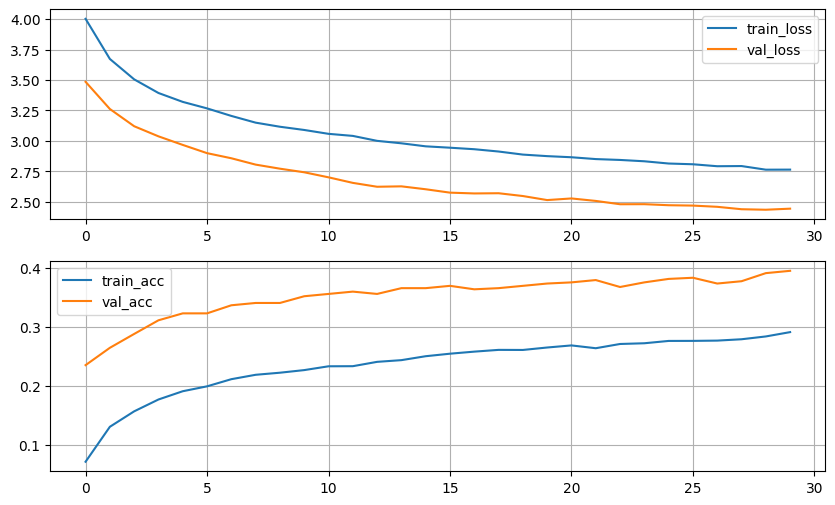

epoch 31: 100%|████████████████████████████████████████████████| 124/124 [03:49<00:00,  1.85s/it, loss=2.64, acc=0.333]


Train | Avg_loss: 2.769424, Accuracy: 28.3%
Validation | Avg_loss: 2.412225, Accuracy: 39.1%


epoch 32: 100%|████████████████████████████████████████████████| 124/124 [03:50<00:00,  1.86s/it, loss=2.75, acc=0.333]


Train | Avg_loss: 2.755272, Accuracy: 29.1%
Validation | Avg_loss: 2.426684, Accuracy: 38.9%


epoch 33: 100%|████████████████████████████████████████████████| 124/124 [03:50<00:00,  1.86s/it, loss=2.98, acc=0.283]


Train | Avg_loss: 2.755076, Accuracy: 28.8%
Validation | Avg_loss: 2.441309, Accuracy: 40.6%
new best acc: 0.40625


epoch 34: 100%|████████████████████████████████████████████████| 124/124 [03:50<00:00,  1.86s/it, loss=2.83, acc=0.233]


Train | Avg_loss: 2.749107, Accuracy: 29.1%
Validation | Avg_loss: 2.416808, Accuracy: 39.1%


epoch 35: 100%|██████████████████████████████████████████████████| 124/124 [03:51<00:00,  1.87s/it, loss=2.57, acc=0.4]


Train | Avg_loss: 2.726098, Accuracy: 29.6%
Validation | Avg_loss: 2.419861, Accuracy: 40.2%


epoch 36: 100%|████████████████████████████████████████████████| 124/124 [03:49<00:00,  1.85s/it, loss=2.94, acc=0.117]


Train | Avg_loss: 2.722555, Accuracy: 29.7%
Validation | Avg_loss: 2.393884, Accuracy: 41.2%
new best acc: 0.4117542654275894


epoch 37: 100%|███████████████████████████████████████████████████| 124/124 [03:49<00:00,  1.85s/it, loss=3.3, acc=0.2]


Train | Avg_loss: 2.719269, Accuracy: 29.6%
Validation | Avg_loss: 2.398077, Accuracy: 40.2%


epoch 38: 100%|████████████████████████████████████████████████| 124/124 [03:49<00:00,  1.85s/it, loss=2.71, acc=0.333]


Train | Avg_loss: 2.705095, Accuracy: 29.5%
Validation | Avg_loss: 2.406942, Accuracy: 38.9%


epoch 39: 100%|██████████████████████████████████████████████████| 124/124 [03:48<00:00,  1.84s/it, loss=2.78, acc=0.3]


Train | Avg_loss: 2.707050, Accuracy: 29.9%
Validation | Avg_loss: 2.395130, Accuracy: 41.0%


epoch 40: 100%|████████████████████████████████████████████████| 124/124 [03:48<00:00,  1.84s/it, loss=2.31, acc=0.433]


Train | Avg_loss: 2.699270, Accuracy: 30.0%
Validation | Avg_loss: 2.394688, Accuracy: 39.8%


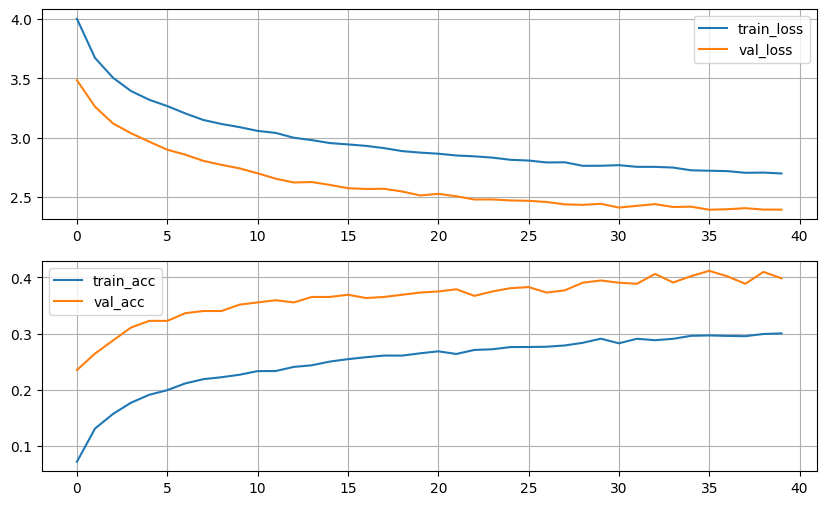

epoch 41: 100%|████████████████████████████████████████████████| 124/124 [03:49<00:00,  1.85s/it, loss=2.46, acc=0.383]


Train | Avg_loss: 2.675844, Accuracy: 30.7%
Validation | Avg_loss: 2.393635, Accuracy: 41.0%


epoch 42: 100%|████████████████████████████████████████████████| 124/124 [03:48<00:00,  1.84s/it, loss=2.82, acc=0.283]


Train | Avg_loss: 2.687890, Accuracy: 30.7%
Validation | Avg_loss: 2.405850, Accuracy: 39.6%


epoch 43: 100%|█████████████████████████████████████████████████| 124/124 [03:48<00:00,  1.84s/it, loss=2.5, acc=0.333]


Train | Avg_loss: 2.675917, Accuracy: 30.2%
Validation | Avg_loss: 2.379216, Accuracy: 41.2%


epoch 44: 100%|██████████████████████████████████████████████████| 124/124 [03:48<00:00,  1.84s/it, loss=2.51, acc=0.3]


Train | Avg_loss: 2.670345, Accuracy: 30.4%
Validation | Avg_loss: 2.373161, Accuracy: 41.0%


epoch 45: 100%|████████████████████████████████████████████████| 124/124 [03:50<00:00,  1.85s/it, loss=2.91, acc=0.283]


Train | Avg_loss: 2.673130, Accuracy: 30.7%
Validation | Avg_loss: 2.372308, Accuracy: 40.6%


epoch 46: 100%|██████████████████████████████████████████████████| 124/124 [03:49<00:00,  1.85s/it, loss=2.65, acc=0.3]


Train | Avg_loss: 2.675919, Accuracy: 29.9%
Validation | Avg_loss: 2.370864, Accuracy: 40.4%


epoch 47: 100%|████████████████████████████████████████████████| 124/124 [03:48<00:00,  1.84s/it, loss=2.79, acc=0.267]


Train | Avg_loss: 2.664446, Accuracy: 31.1%
Validation | Avg_loss: 2.358885, Accuracy: 40.0%


epoch 48: 100%|█████████████████████████████████████████████████| 124/124 [03:52<00:00,  1.87s/it, loss=2.47, acc=0.35]


Train | Avg_loss: 2.647109, Accuracy: 31.4%
Validation | Avg_loss: 2.366704, Accuracy: 40.2%


epoch 49: 100%|████████████████████████████████████████████████| 124/124 [03:54<00:00,  1.89s/it, loss=2.64, acc=0.317]


Train | Avg_loss: 2.643863, Accuracy: 30.9%
Validation | Avg_loss: 2.366988, Accuracy: 41.2%


epoch 50: 100%|████████████████████████████████████████████████| 124/124 [03:56<00:00,  1.91s/it, loss=2.39, acc=0.367]


Train | Avg_loss: 2.645271, Accuracy: 30.9%
Validation | Avg_loss: 2.347389, Accuracy: 41.0%


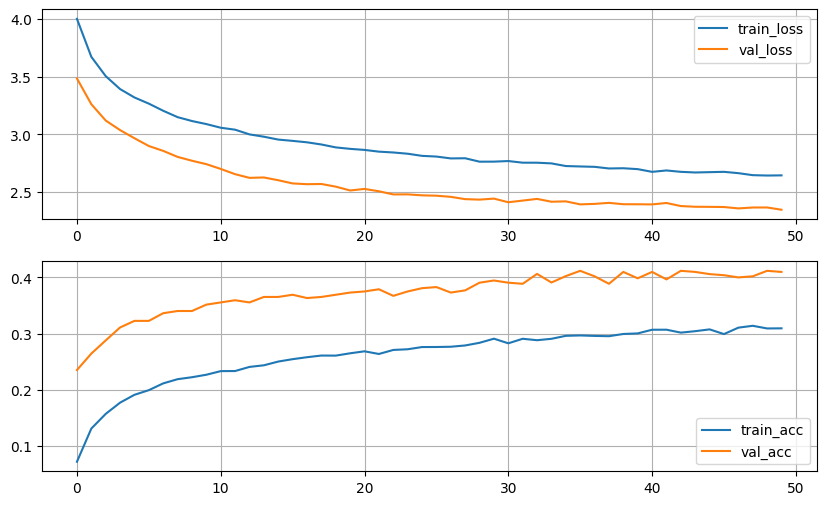

In [15]:
max_epoch = 50
min_epoch = 0
for e in range(min_epoch+1, max_epoch+1):
    train_loss, train_acc = train_loop(office_train_dataloader, p2_model, loss_fn, optimizer)
    val_loss, val_acc = val_loop(office_val_dataloader, p2_model, loss_fn)
    record_append(record, train_loss, train_acc, val_loss, val_acc)
    if val_acc>best_acc:
        best_acc = val_acc
        best_model.load_state_dict(p2_model.state_dict())
        print(f'new best acc: {best_acc}')
        torch.save(p2_model, 'p2_ckpt/best_model_E.pt')
    if e%10==0:
        plot_record(record)
min_epoch = e

In [16]:
torch.save(p2_model, 'p2_ckpt/model_E.pt')

In [58]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [59]:
def same_seeds(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
same_seeds(777)

In [60]:
label2class_dict = {0: 'TV', 1: 'Desk_Lamp', 2: 'Speaker', 3: 'Hammer', 4: 'Folder', 5: 'Laptop', 6: 'Pen', 7: 'Postit_Notes',
    8: 'Mop', 9: 'Mug', 10: 'Radio', 11: 'File_Cabinet', 12: 'Eraser', 13: 'Ruler', 14: 'Couch', 15: 'Trash_Can', 16: 'Webcam', 
    17: 'Backpack', 18: 'Bucket', 19: 'Kettle', 20: 'Batteries', 21: 'Telephone', 22: 'Chair', 23: 'Toys', 24: 'Refrigerator',
    25: 'Clipboards', 26: 'Fork', 27: 'Push_Pin', 28: 'Marker', 29: 'Candles', 30: 'Flipflops', 31: 'Helmet', 32: 'Pencil',
    33: 'Calendar', 34: 'Monitor', 35: 'Shelf', 36: 'Sneakers', 37: 'Soda', 38: 'Bottle', 39: 'Flowers', 40: 'Drill', 41: 'Table',
    42: 'Knives', 43: 'Computer', 44: 'Alarm_Clock',  45: 'Sink', 46: 'Exit_Sign', 47: 'Bed', 48: 'Oven', 49: 'Keyboard', 
    50: 'Paper_Clip', 51: 'Lamp_Shade', 52: 'Scissors', 53: 'Curtains', 54: 'Fan', 55: 'Spoon', 56: 'Screwdriver', 57: 'Glasses',
    58: 'Pan', 59: 'ToothBrush', 60: 'Mouse', 61: 'Printer', 62: 'Calculator', 63: 'Notebook', 64: 'Bike'}

In [61]:
class Test_Dataset(Dataset):
    def __init__(self, img_dir, csv_path, transform=None):
        self.gt = pd.read_csv(csv_path)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.gt)

    def __getitem__(self, idx):
        idx_row = self.gt.loc[idx]
        img_name = idx_row['filename']
        img_path = f'{self.img_dir}/{img_name}'
        image = Image.open(img_path)
        csv_id = idx_row['id']
        if self.transform:
            image = self.transform(image)
        return image, csv_id

In [62]:
batch_size = 128
transform_test = transforms.Compose([transforms.Resize(128),
                                transforms.CenterCrop((128,128)),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                     std=[0.229, 0.224, 0.225])
                               ])

In [63]:
office_test_img_dir = 'D:/NTU/DLCV/hw4/hw4_data/office/val/'
office_test_csv_path = 'D:/NTU/DLCV/hw4/hw4_data/office/test.csv'

office_test_dataset = Test_Dataset(office_test_img_dir, office_test_csv_path, transform=transform_test)
office_test_dataloader = DataLoader(office_test_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)

In [64]:
class model_ft(nn.Module):
    def __init__(self):
        super(model_ft, self).__init__()
        self.backbone = models.resnet50(weights=None)
        self.classifier = nn.Sequential(nn.BatchNorm1d(1000),
                                        nn.ReLU(),
                                        nn.Dropout(p=0.5),
                                        nn.Linear(1000, 512),
                                        nn.BatchNorm1d(512),
                                        nn.ReLU(),
                                        nn.Dropout(p=0.5),
                                        nn.Linear(512, 65)
                                       )
    def forward(self, x):
        x = self.backbone(x)
        x = self.classifier(x)
        return x
    
p2_model = model_ft()
p2_model = torch.load('p2_ckpt/best_model_C.pt')
p2_model.to(device)

model_ft(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
        

In [65]:
office_test_dataset.gt

,id,filename,label
0,0,Fork00005.jpg,None
1,1,Fork00002.jpg,None
2,2,Fork00032.jpg,None
3,3,Radio00039.jpg,None
4,4,Radio00020.jpg,None
...,...,...,...
401,401,Notebook00020.jpg,None
402,402,Notebook00025.jpg,None
403,403,Notebook00005.jpg,None
404,404,Notebook00002.jpg,None


In [66]:
def test_loop(dataloader, model):
    model.eval()
    with torch.no_grad():
        for images, ids in dataloader:
            images = images.to(device)
            pred_labels = model(images)
            pred_labels = pred_labels.argmax(1)
            
            for j, i in enumerate(ids):
                dataloader.dataset.gt.loc[i.item(),'label'] = label2class_dict[pred_labels[j].item()]

In [67]:
test_loop(office_test_dataloader, p2_model)

In [68]:
office_test_dataloader.dataset.gt

,id,filename,label
0,0,Fork00005.jpg,Pen
1,1,Fork00002.jpg,Desk_Lamp
2,2,Fork00032.jpg,Pencil
3,3,Radio00039.jpg,Radio
4,4,Radio00020.jpg,Radio
...,...,...,...
401,401,Notebook00020.jpg,Notebook
402,402,Notebook00025.jpg,Notebook
403,403,Notebook00005.jpg,Notebook
404,404,Notebook00002.jpg,Notebook


In [69]:
def check_acc(gt):
    acc = 0
    for i in range(len(gt)):
        if gt.loc[i, 'filename'][:-9] == gt.loc[i, 'label']:
            acc += 1
    print(acc/len(gt))

In [70]:
check_acc(office_test_dataloader.dataset.gt)

0.5246305418719212


In [16]:
output_csv_path = 'D:/NTU/DLCV/hw4/hw4_data/office/test_pred.csv'
office_test_dataloader.dataset.gt.to_csv(output_csv_path, index=False)

In [4]:
import pandas as pd

In [5]:
gt = pd.read_csv('hw4_data/office/val.csv')
pred = pd.read_csv('hw4-Willy-Wen/p2_output.csv')

In [11]:
(gt['label']==pred['label']).sum()/len(gt)

0.5246305418719212